Auteur : Kévin Ferreira
Groupe : Anatole Martenne, Abdellah Dighab

J'ai effectué un lissage de mes données sur une période de 15 secondes afin d'en atténuer les variations et d'obtenir des informations plus stables. Ensuite, j'ai appliqué des conditions spécifiques pour discriminer les données en fonction de leur tendance, en créant des seuils correspondant à différents états. Par exemple, j'ai attribué des valeurs de 0, 1 et -1 à la variable "BPOS" pour représenter les états stables, croissants et décroissants respectivement. À partir de ces informations, j'ai créé une nouvelle colonne qui permet de catégoriser les différentes phases de mouvement en fonction de la tendance et de l'état de charge. Cette colonne permet ainsi de définir si le système est en montée à vide, en montée en charge, en descente à vide, en descente en charge, stable, ou si l'état est inconnu, offrant une vue d'ensemble claire sur l'évolution des données.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

data = [pd.read_csv('DATA/' + f) for f in os.listdir('DATA') if f.endswith('.csv')] 

# Fonction de traitement
def process_dataframe(df):
    # Sélectionner les colonnes nécessaires
    df = df[["TIME", "HKLA", "BPOS", "WOBA", "SPM1", "SPM2", "SPPA", "MFIA"]]

    # Appliquer les conditions sur les colonnes HKLA et WOBA
    def cond_HKLA(x):
        if x < 20:
            return 0
        elif x > 20:
            return 1
        return x

    df['HKLA_cond'] = df['HKLA'].apply(cond_HKLA)

    def cond_WOBA(x):
        if x > 0:
            return 1
        elif x <= 0:
            return 0
        return x

    df['WOBA_cond'] = df['WOBA'].apply(cond_WOBA)

    # Appliquer la logique de circulation
    df["circulation"] = ((df["SPM1"] > 0) & 
                         (df["SPM2"] > 0) & 
                         (df["SPPA"] > 6) & 
                         (df["MFIA"] > 0)).astype(int)

    # Vérifier si la colonne 'TIME' existe
    if 'TIME' not in df.columns:
        raise KeyError("La colonne 'TIME' est manquante dans le dataframe.")

    # Convertir la colonne TIME en datetime si ce n'est pas déjà fait
    df["TIME"] = pd.to_datetime(df["TIME"], errors='coerce')

    # Supprimer les lignes où la conversion de 'TIME' a échoué
    df = df.dropna(subset=['TIME'])

    # Appliquer une moyenne mobile sur une fenêtre de 15 secondes
    df.set_index("TIME", inplace=True)
    df["BPOS_lisse"] = df["BPOS"].rolling("0.25min").mean()

    df["BPOS_variation"] = df["BPOS_lisse"].diff()

    # Définir la tendance locale
    df["BPOS_tendance"] = df["BPOS_variation"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    # Logique conditionnelle pour calculer mvt_poids
    df['BPOS_tendance'] = df['BPOS_tendance'].astype(int)
    df['HKLA_cond'] = df['HKLA_cond'].astype(int)

    df["mvt_poids"] = df.apply(lambda row:
        "Montee a vide" if row['BPOS_tendance'] == 1 and row['HKLA_cond'] == 0 else
        "Montee en charge" if row['BPOS_tendance'] == 1 and row['HKLA_cond'] == 1 else
        "Descente a vide" if row['BPOS_tendance'] == -1 and row['HKLA_cond'] == 0 else
        "Descente en charge" if row['BPOS_tendance'] == -1 and row['HKLA_cond'] == 1 else
        "Stable" if row['BPOS_tendance'] == 0 else
        "Inconnu", axis=1)

    return df

# Appliquer le traitement sur chaque DataFrame dans la liste 'data'
processed_data = [process_dataframe(df) for df in data]


C:\Users\kevin\AppData\Local\Temp\ipykernel_18260\2047842561.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HKLA_cond'] = df['HKLA'].apply(cond_HKLA)
C:\Users\kevin\AppData\Local\Temp\ipykernel_18260\2047842561.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WOBA_cond'] = df['WOBA'].apply(cond_WOBA)
C:\Users\kevin\AppData\Local\Temp\ipykernel_18260\2047842561.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [5]:
processed_data[-1]

HKLA      BPOS     WOBA  SPM1  SPM2   SPPA     MFIA  \
TIME                                                                          
2025-02-25 00:00:02  50.8253  10.29650  14.9120  87.0  87.0  183.0  2815.32   
2025-02-25 00:00:05  50.9526  10.29650  14.7850  93.0  93.0  180.0  3009.48   
2025-02-25 00:00:07  51.5042  10.29090  14.2334  87.0  87.0  188.0  2815.32   
2025-02-25 00:00:09  51.4617  10.28880  14.2760  87.0  87.0  188.0  2815.32   
2025-02-25 00:00:11  51.6314  10.28150  14.1063  87.0  87.0  182.0  2815.32   
...                      ...       ...      ...   ...   ...    ...      ...   
2025-02-25 23:59:50  77.6406   4.64488   0.0000  46.0   0.0   39.0   744.28   
2025-02-25 23:59:52  78.4043   4.64488   0.0000  51.0   0.0   39.0   825.18   
2025-02-25 23:59:54  77.9800   4.64488   0.0000  51.0   0.0   45.0   825.18   
2025-02-25 23:59:56  77.7255   4.64488   0.0000  46.0   0.0   38.0   744.28   
2025-02-25 23:59:58  77.6406   4.64488   0.0000  51.0   0.0   33.0   825.18   

                     HKLA_cond  WOBA_cond  circulation  BPOS_lisse  \
TIME                                                                 
2025-02-25 00:00:02          1          1            1   10.296500   
2025-02-25 00:00:05          1          1            1   10.296500   
2025-02-25 00:00:07          1          1            1   10.294633   
2025-02-25 00:00:09          1          1            1   10.293175   
2025-02-25 00:00:11          1          1            1   10.290840   
...                        ...        ...          ...         ...   
2025-02-25 23:59:50          1          0            0    4.644880   
2025-02-25 23:59:52          1          0            0    4.644880   
2025-02-25 23:59:54          1          0            0    4.644880   
2025-02-25 23:59:56          1          0            0    4.644880   
2025-02-25 23:59:58          1          0            0    4.644880   

                     BPOS_variation  BPOS_tendance           mvt_poids  
TIME                                                                    
2025-02-25 00:00:02             NaN              0              Stable  
2025-02-25 00:00:05        0.000000              0              Stable  
2025-02-25 00:00:07       -0.001867             -1  Descente en charge  
2025-02-25 00:00:09       -0.001458             -1  Descente en charge  
2025-02-25 00:00:11       -0.002335             -1  Descente en charge  
...                             ...            ...                 ...  
2025-02-25 23:59:50        0.000000              0              Stable  
2025-02-25 23:59:52        0.000000              0              Stable  
2025-02-25 23:59:54        0.000000              0              Stable  
2025-02-25 23:59:56        0.000000              0              Stable  
2025-02-25 23:59:58        0.000000              0              Stable  

[40737 rows x 14 columns]

# Plot de chaque jour, BPOS et HKLA en fonction du temps

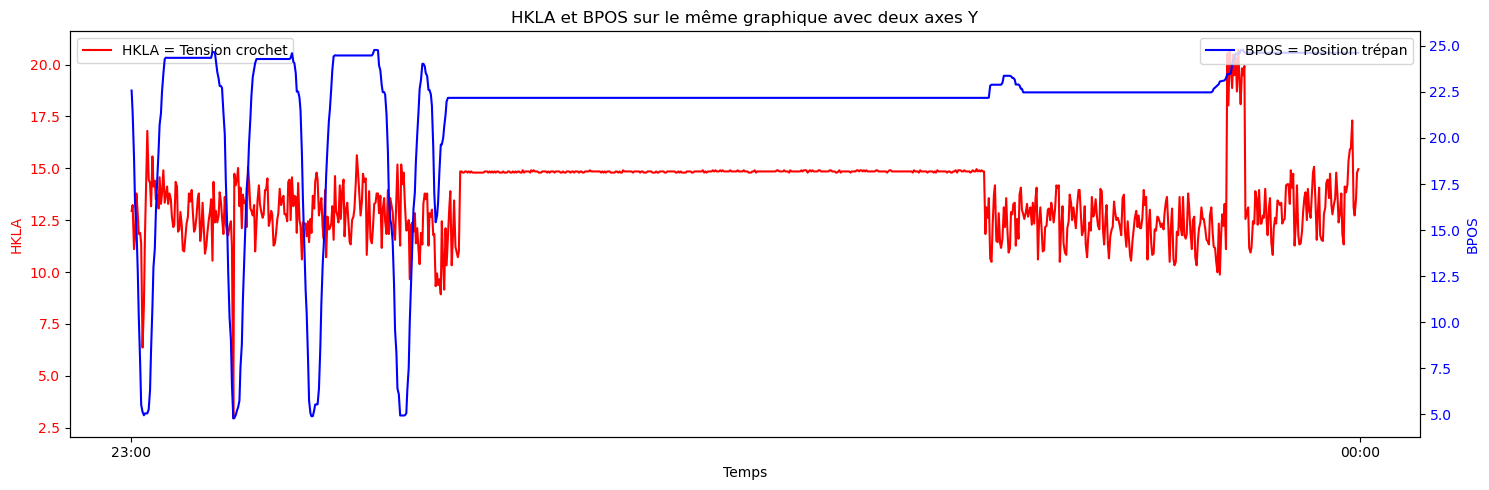

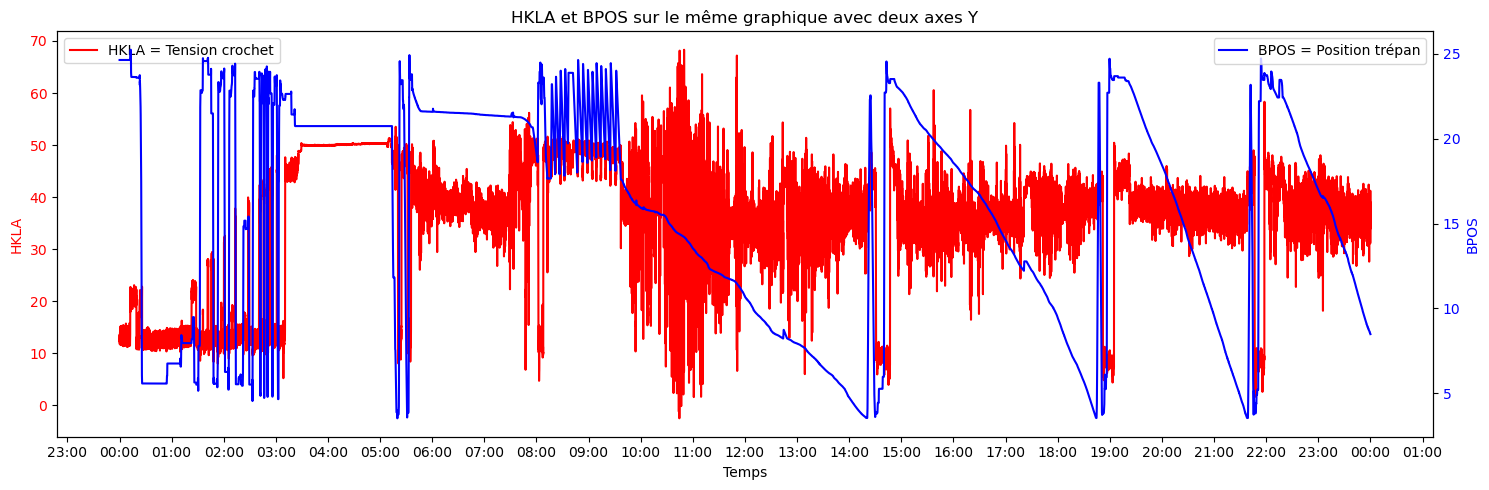

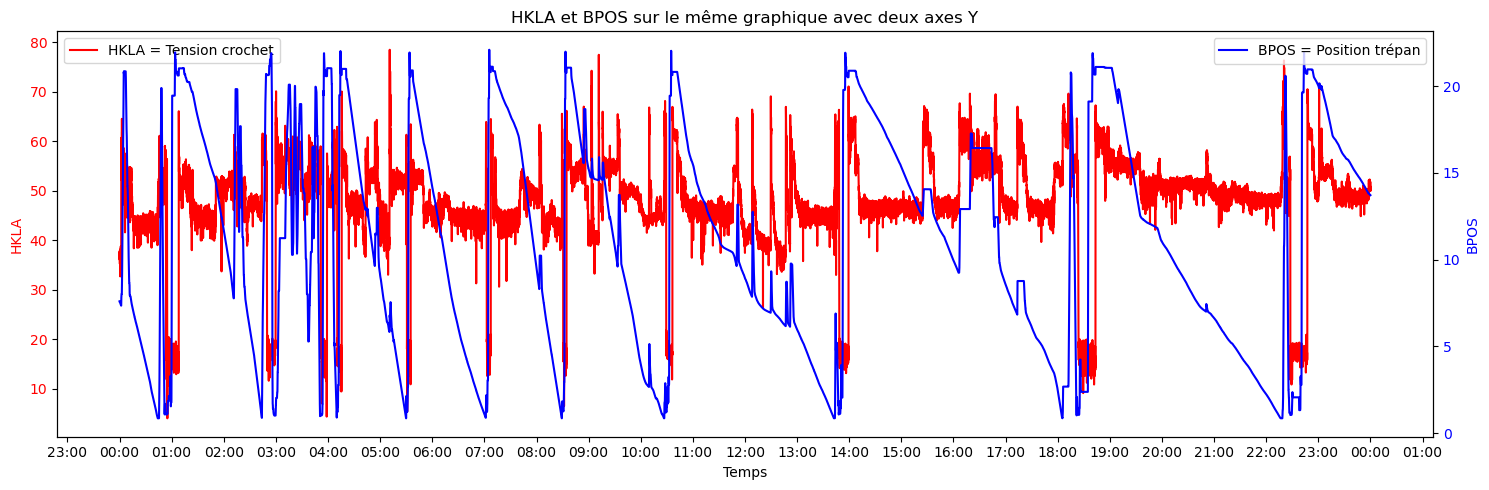

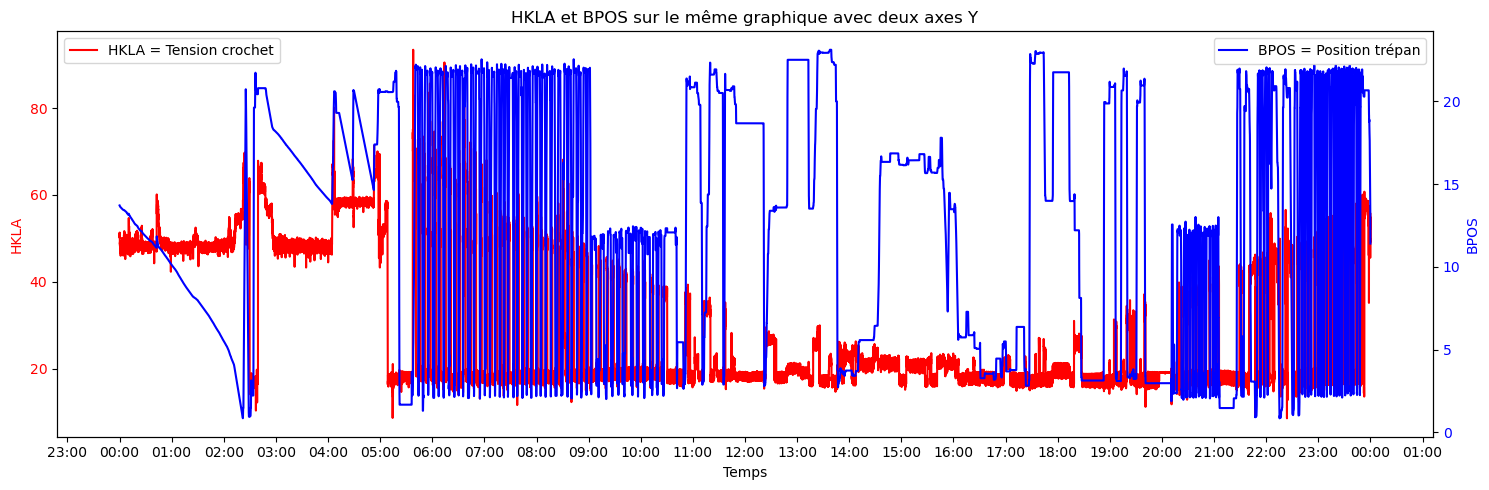

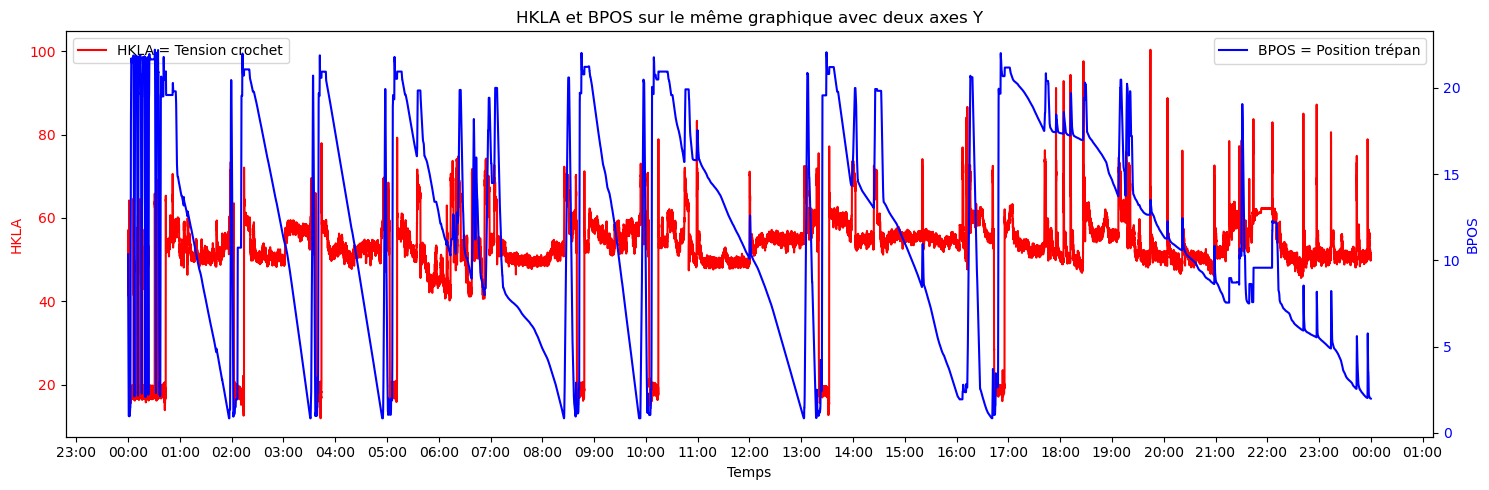

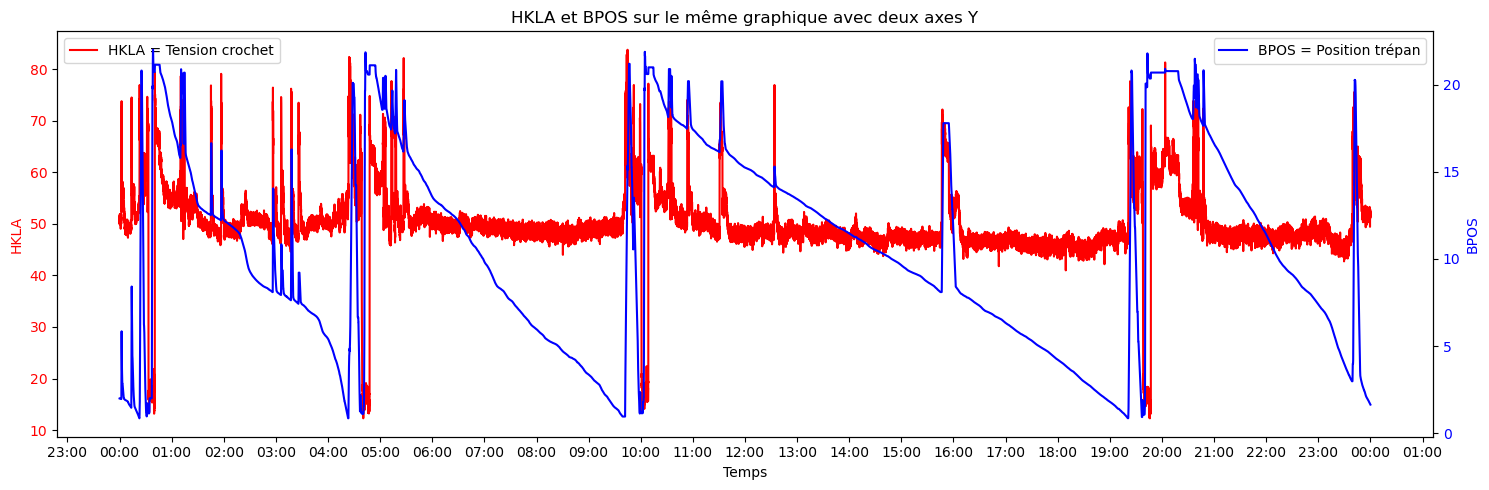

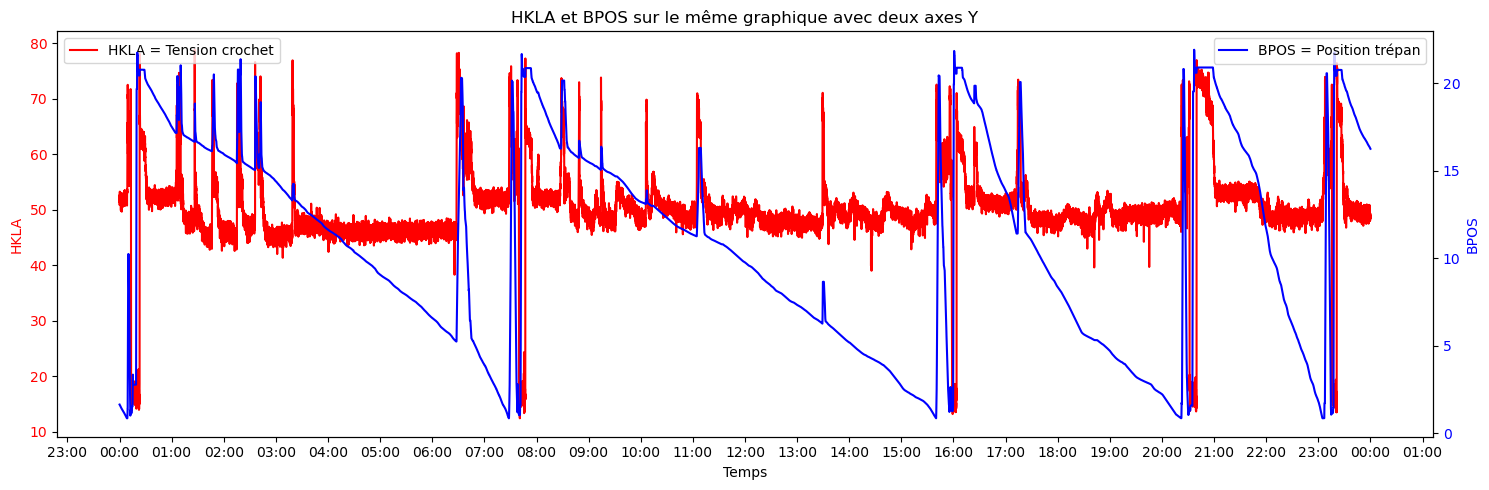

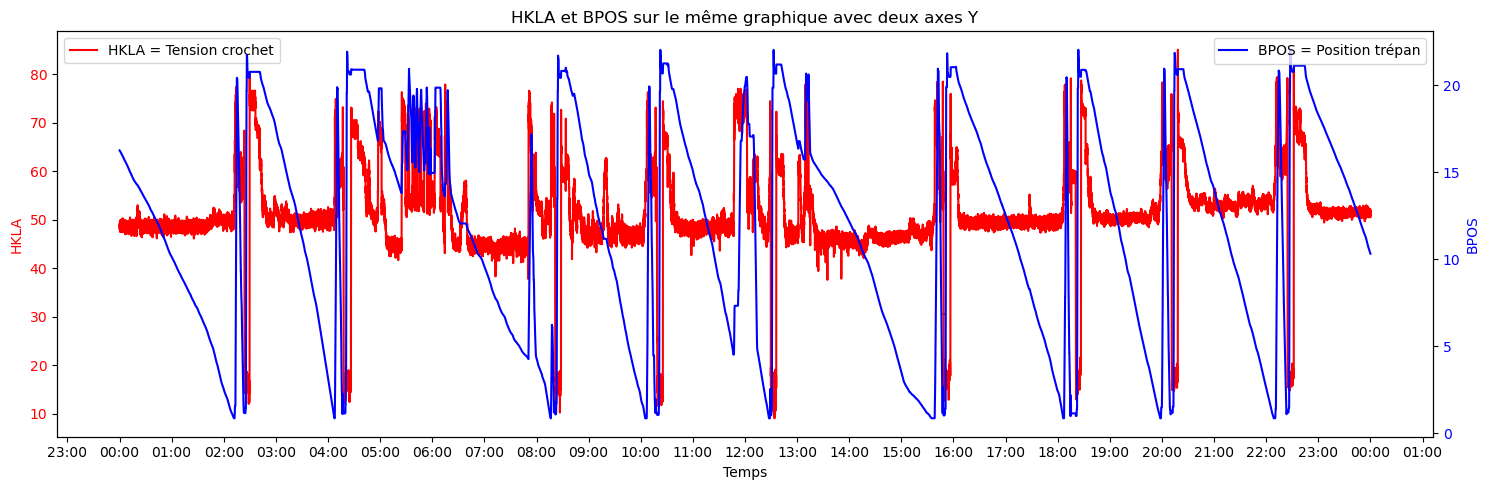

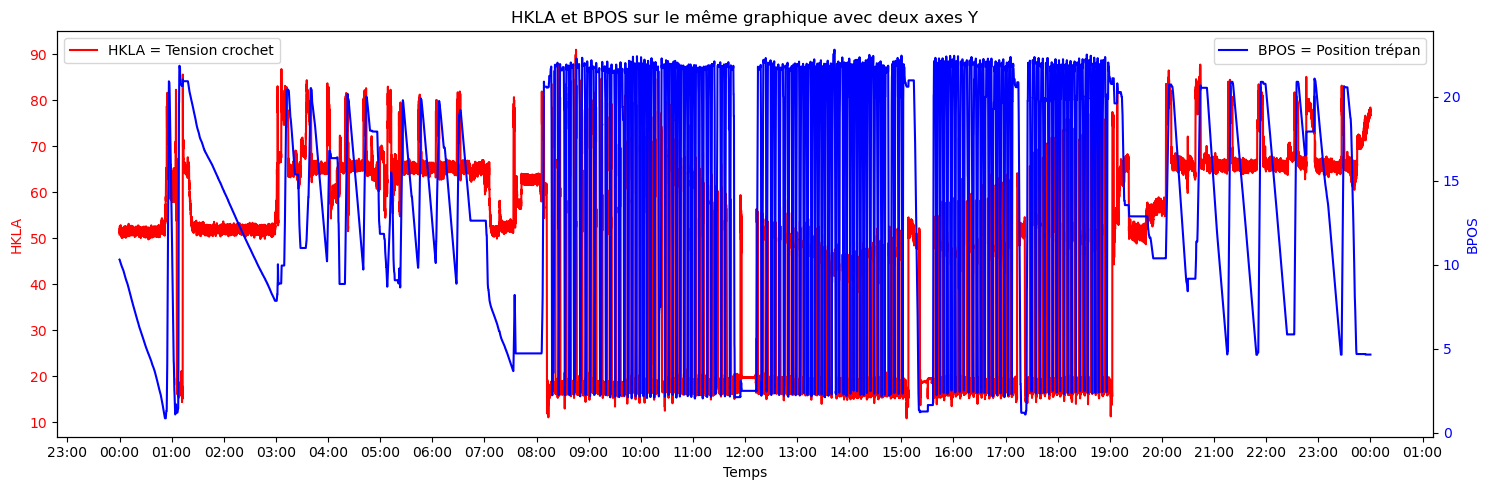

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Fonction pour attribuer une couleur en fonction de la valeur de 'mvt_poids'
def get_color(mvt_poids_value):
    color_map = {
        "Montee a vide": 'red',
        "Montee en charge": 'green',
        "Descente a vide": 'blue',
        "Descente en charge": 'orange',
        "Stable": 'gray',
        "Inconnu": 'black'
    }
    return color_map.get(mvt_poids_value, 'black')  # Retourne noir par défaut si pas trouvé

# Boucle pour chaque DataFrame dans processed_data
for df in processed_data:
    df.reset_index(inplace=True)  # Réinitialiser l'index pour pouvoir accéder à la colonne 'TIME'
    
    fig, ax1 = plt.subplots(figsize=(15, 5))  # Créer une nouvelle figure et axe pour le premier graphique

    # Plot pour HKLA sur le premier axe Y
    ax1.plot(df['TIME'], df['HKLA'], label='HKLA = Tension crochet', color='r')
    ax1.set_xlabel('Temps')
    ax1.set_ylabel('HKLA', color='r')
    ax1.tick_params(axis='y', labelcolor='r')

    # Créer un deuxième axe Y pour BPOS
    ax2 = ax1.twinx()
    
    # Plot pour BPOS sur le deuxième axe Y
    ax2.plot(df['TIME'], df['BPOS'], label='BPOS = Position trépan', color='b')
    ax2.set_ylabel('BPOS', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    # Ajouter les légendes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Formatage de l'axe X pour afficher les heures
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Définit les ticks toutes les heures
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format de l'heure : Heure:Minute
    plt.xticks(rotation=45)  # Rotation des labels de l'axe X pour lisibilité

    # Ajouter un titre
    plt.title('HKLA et BPOS sur le même graphique avec deux axes Y')

    # Afficher le graphique
    plt.tight_layout()
    plt.show()


# Coloriser HKLA par 'mvt_poids' et afficher BPOS en transparent bleu

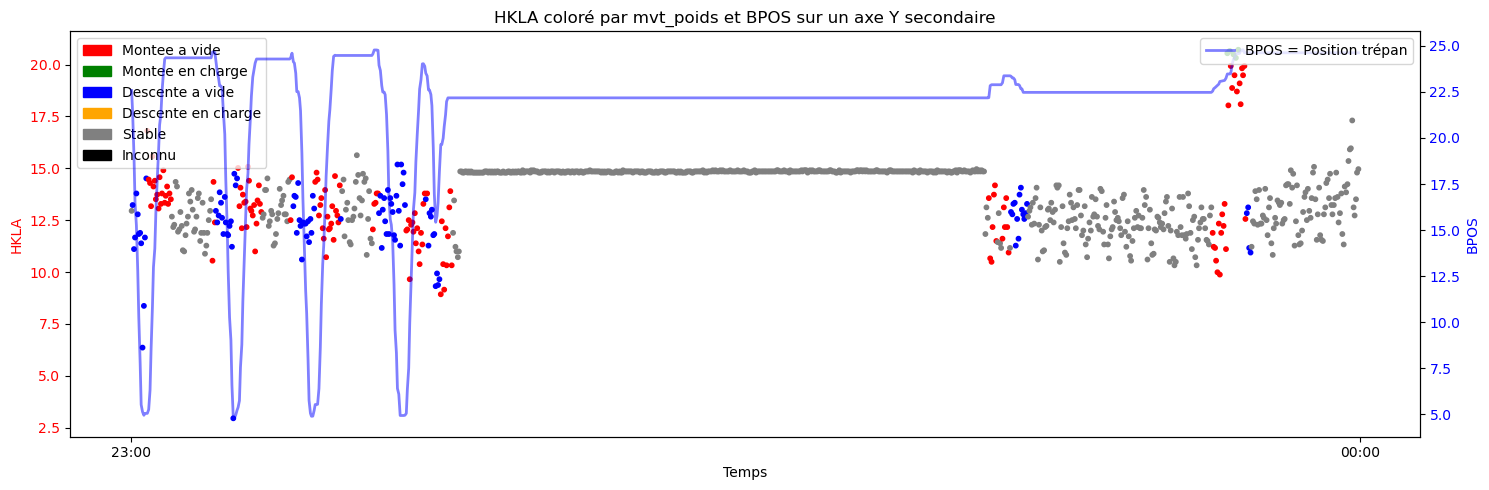

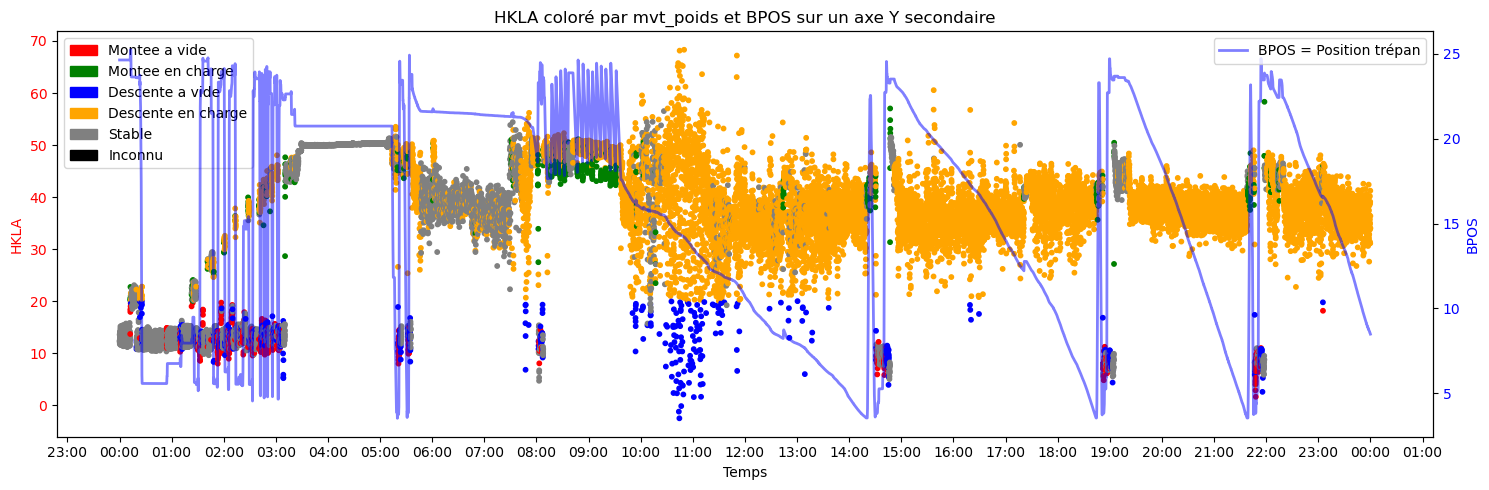

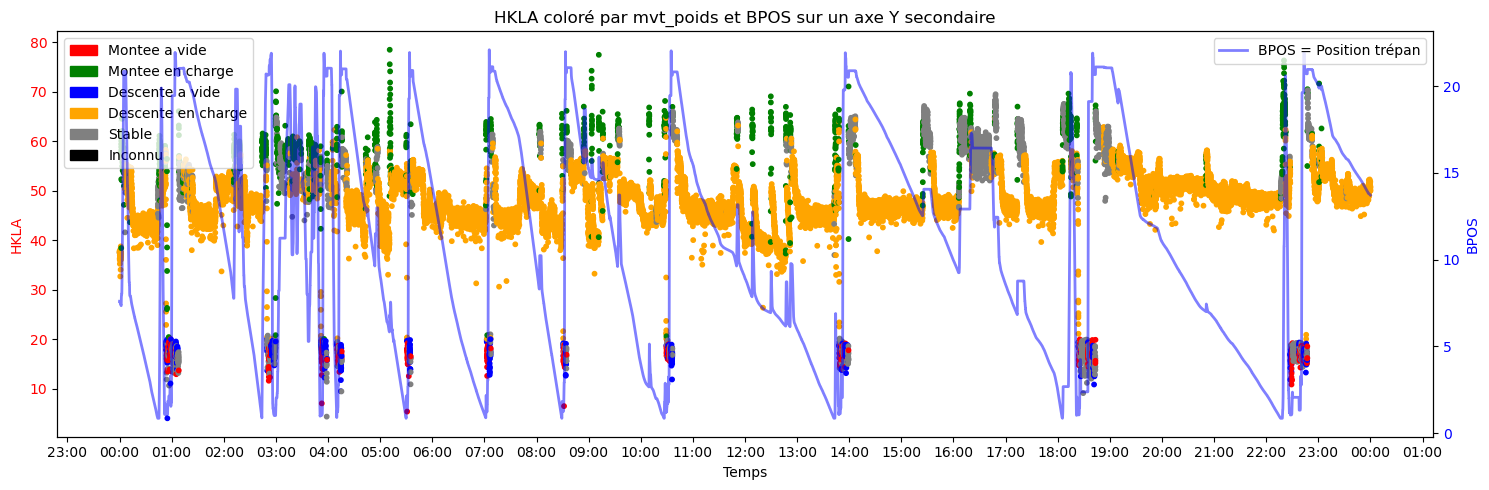

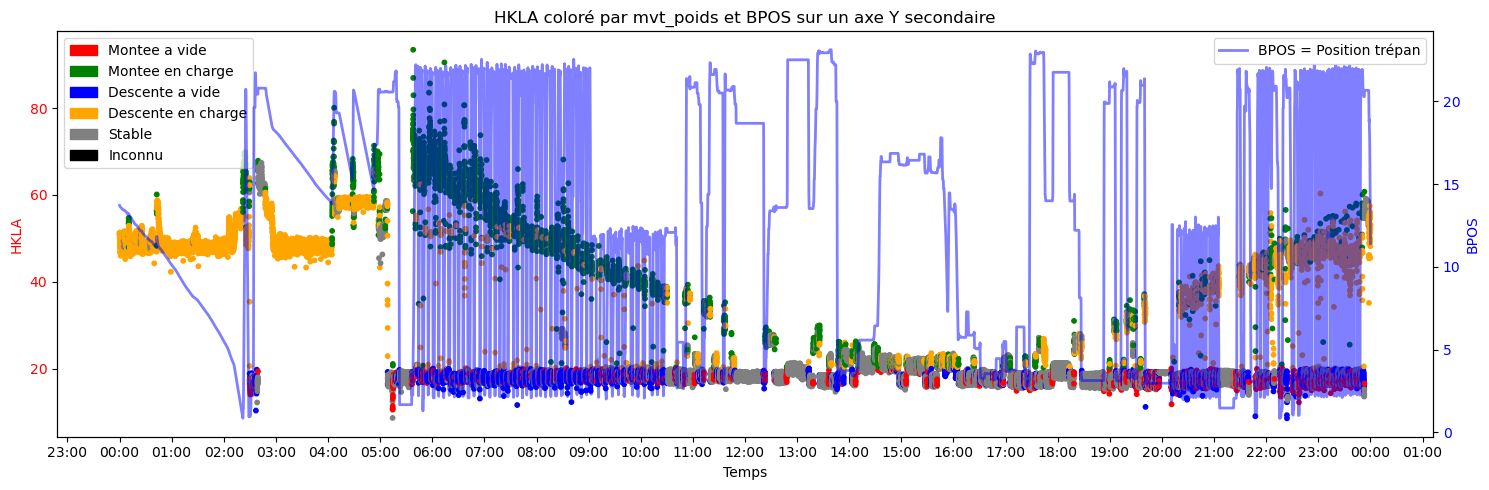

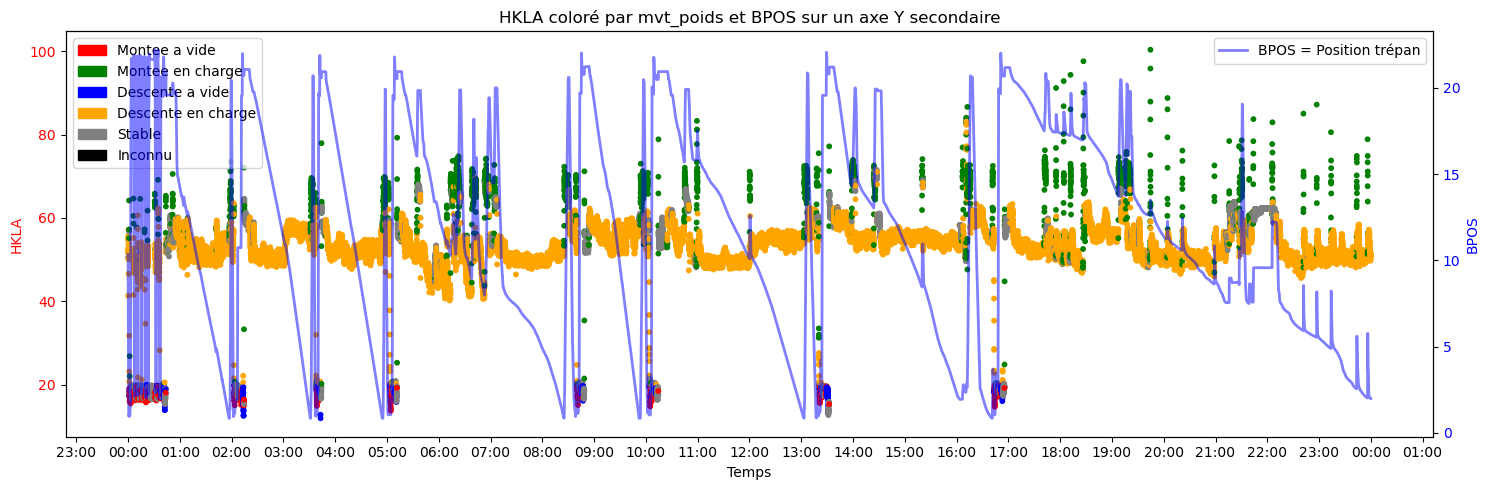

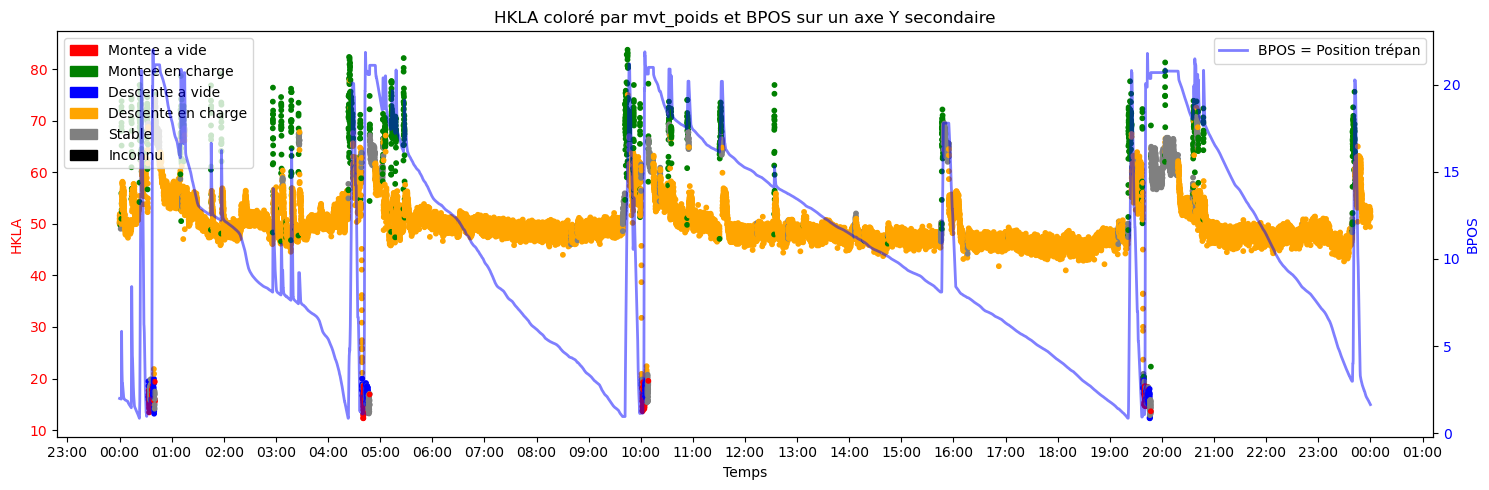

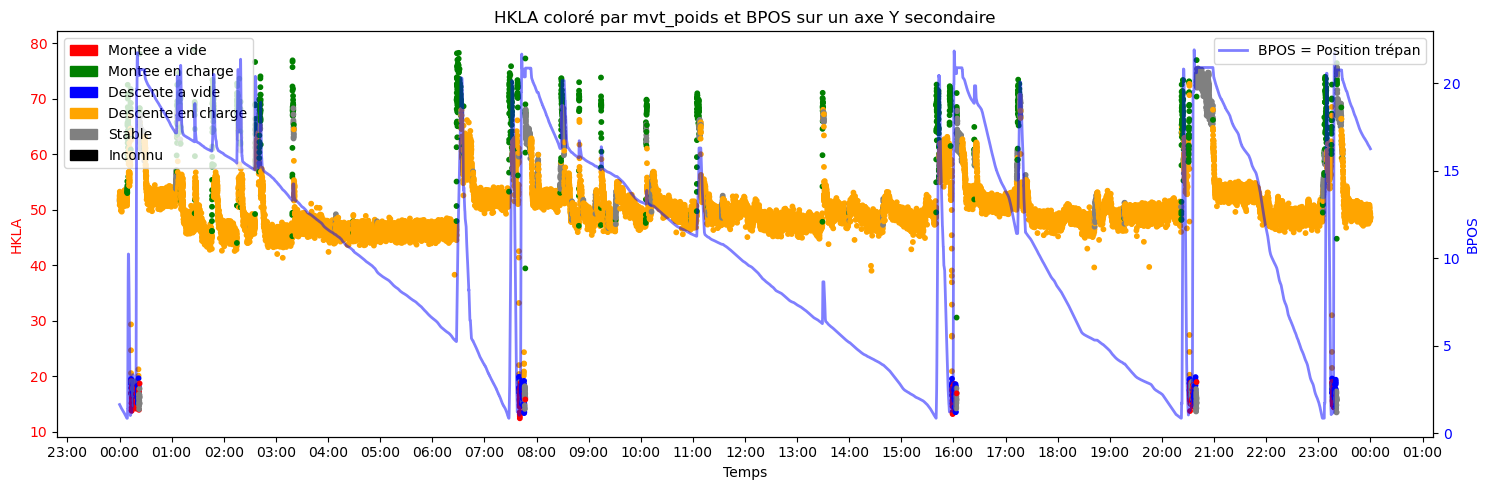

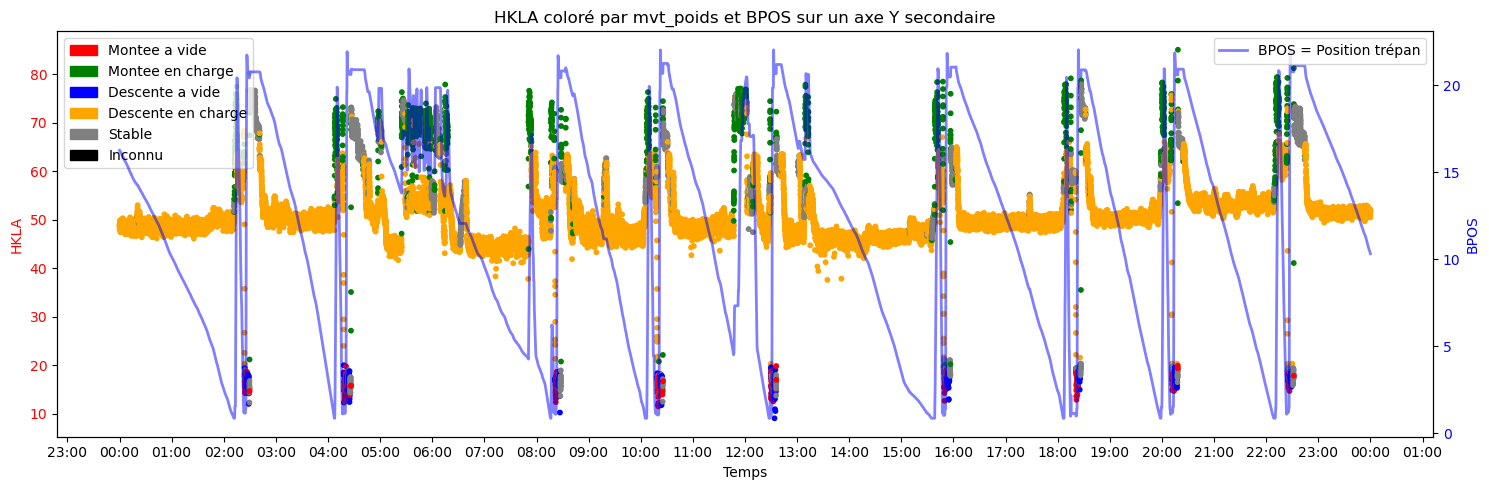

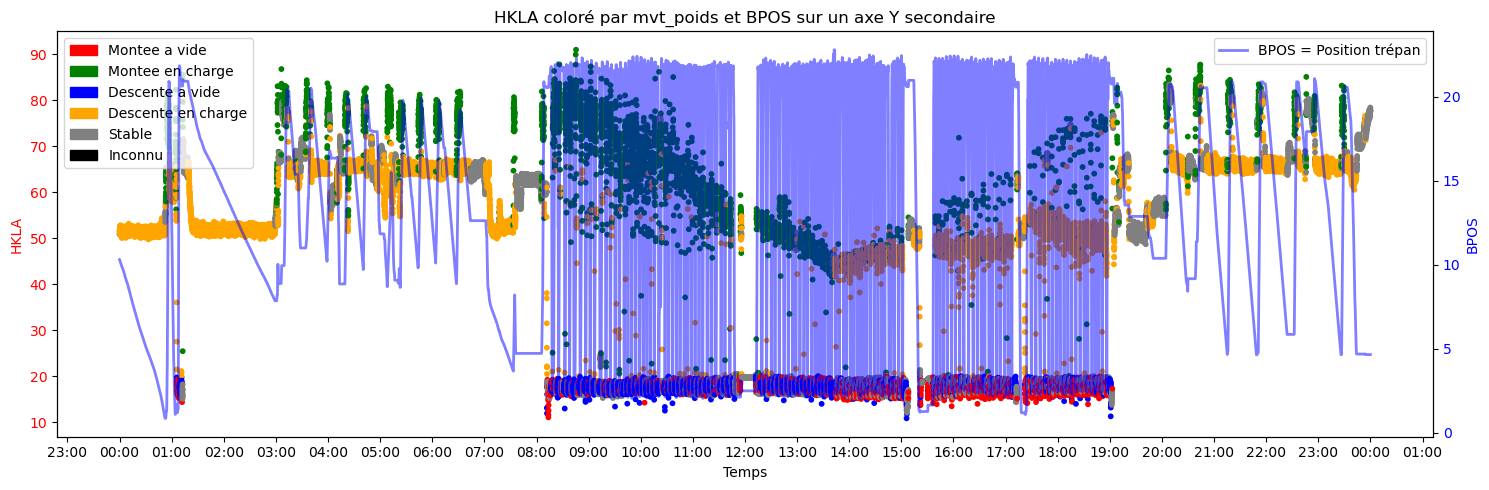

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches  # Pour la gestion de la légende personnalisée

# Fonction pour attribuer une couleur en fonction de la valeur de 'mvt_poids'
def get_color(mvt_poids_value):
    color_map = {
        "Montee a vide": 'red',
        "Montee en charge": 'green',
        "Descente a vide": 'blue',
        "Descente en charge": 'orange',
        "Stable": 'gray',
        "Inconnu": 'black'
    }
    return color_map.get(mvt_poids_value, 'black')  # Retourne noir par défaut si pas trouvé

# Boucle pour chaque DataFrame dans processed_data
for df in processed_data:
    df.reset_index(drop=True, inplace=True)  # Réinitialiser l'index sans ajouter l'index comme colonne

    fig, ax1 = plt.subplots(figsize=(15, 5))  # Créer une nouvelle figure et axe pour le premier graphique

    # Colorier les points de HKLA en fonction de 'mvt_poids' sur l'axe Y de gauche
    colors_hkla = df['mvt_poids'].apply(get_color)  # Assigner les couleurs à chaque point en fonction de 'mvt_poids'
    scatter_hkla = ax1.scatter(df['TIME'], df['HKLA'], c=colors_hkla, label='HKLA = Tension crochet', marker='o', s=10)

    ax1.set_xlabel('Temps')
    ax1.set_ylabel('HKLA', color='r')
    ax1.tick_params(axis='y', labelcolor='r')

    # Créer un deuxième axe Y pour BPOS
    ax2 = ax1.twinx()

    # Tracer BPOS en tant que ligne continue avec une couleur uniforme (par exemple, bleu) et transparence
    ax2.plot(df['TIME'], df['BPOS'], c='blue', label='BPOS = Position trépan', lw=2, alpha=0.5)  # Ligne continue pour BPOS avec transparence (alpha)

    ax2.set_ylabel('BPOS', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    # Créer la légende personnalisée pour mvt_poids
    color_map = {
        "Montee a vide": 'red',
        "Montee en charge": 'green',
        "Descente a vide": 'blue',
        "Descente en charge": 'orange',
        "Stable": 'gray',
        "Inconnu": 'black'
    }

    # Créer des éléments de légende pour chaque type de mvt_poids
    legend_labels = [mpatches.Patch(color=color_map[key], label=key) for key in color_map]

    # Ajouter la légende pour mvt_poids
    ax1.legend(handles=legend_labels, loc='upper left')

    # Ajouter une légende pour BPOS
    ax2.legend(loc='upper right')

    # Formatage de l'axe X pour afficher les heures
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Définit les ticks toutes les heures
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format de l'heure : Heure:Minute
    plt.xticks(rotation=45)  # Rotation des labels de l'axe X pour lisibilité

    # Ajouter un titre
    plt.title('HKLA coloré par mvt_poids et BPOS sur un axe Y secondaire')

    # Afficher le graphique
    plt.tight_layout()
    plt.show()


# Afficher BPOS en colorisation par mvt_poids (descente en charge, montée en charge, etc.) et afficher HKLA en transparent rouge

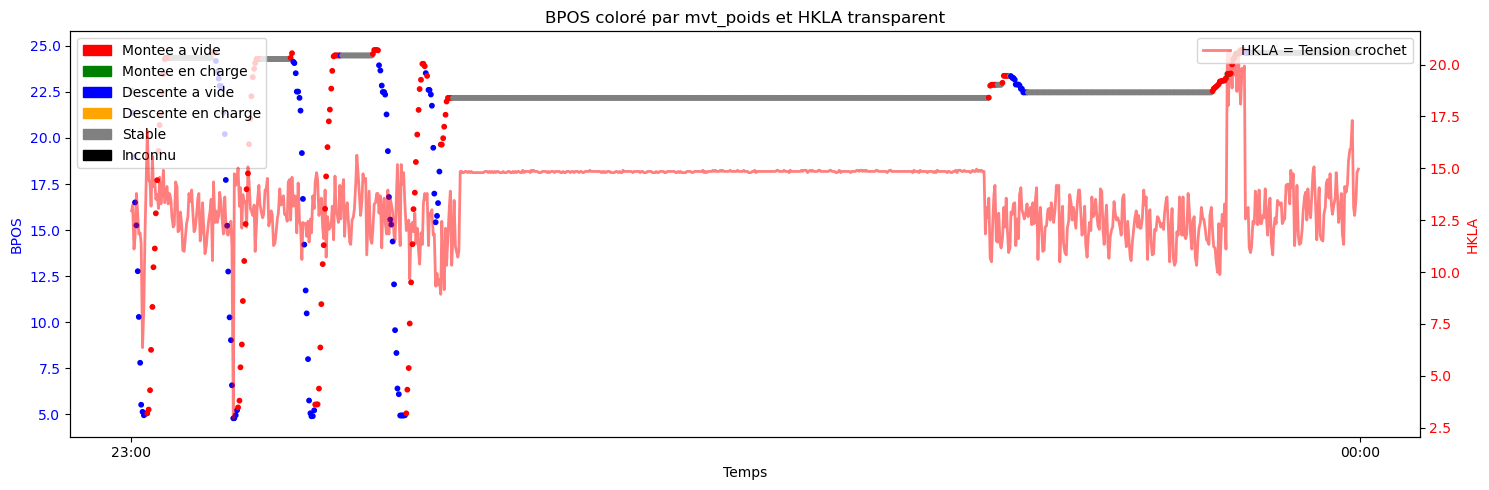

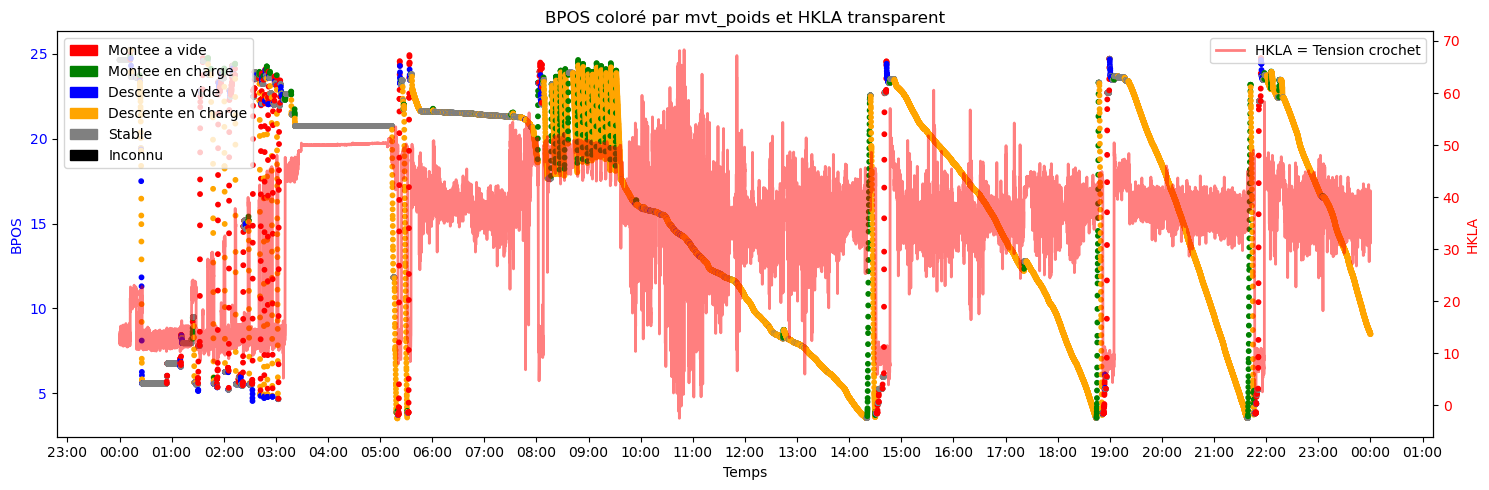

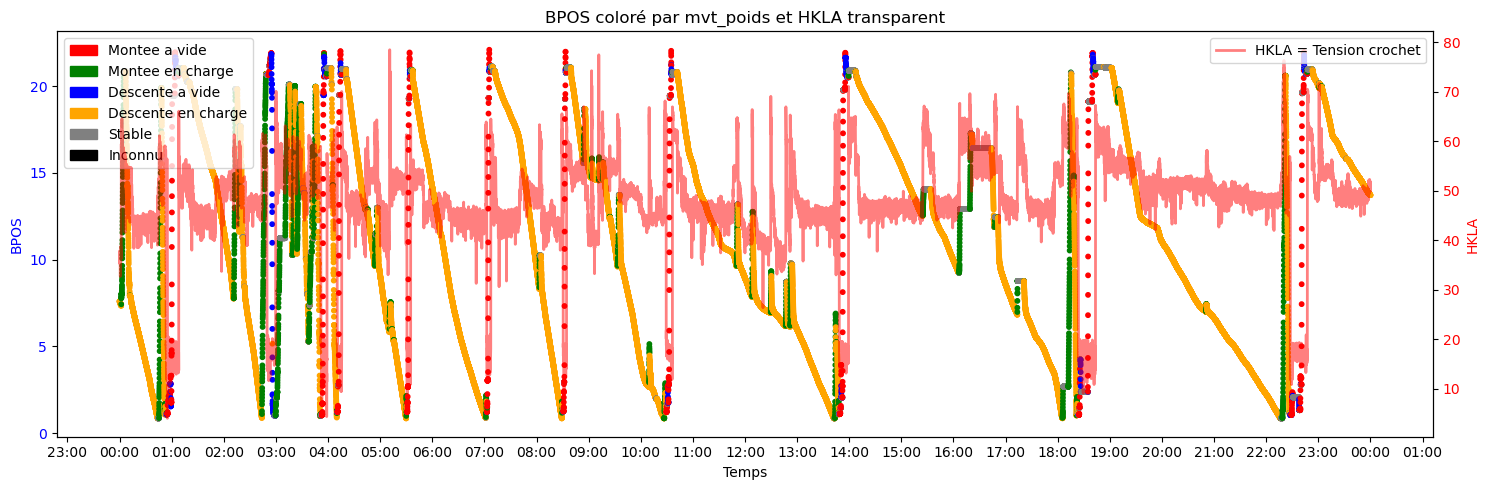

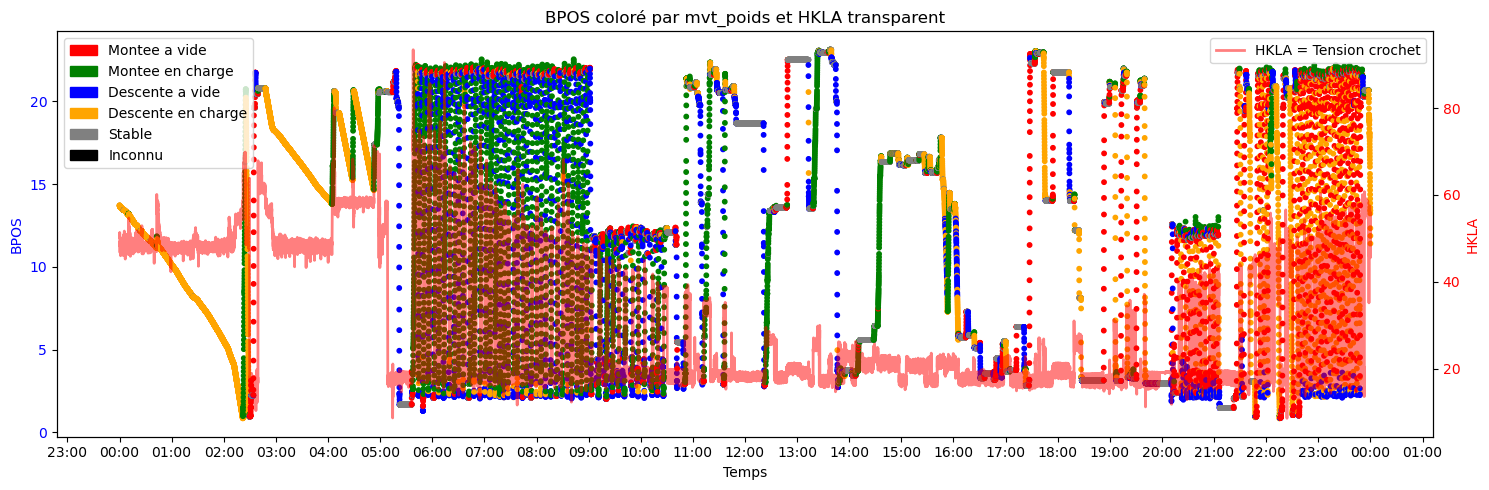

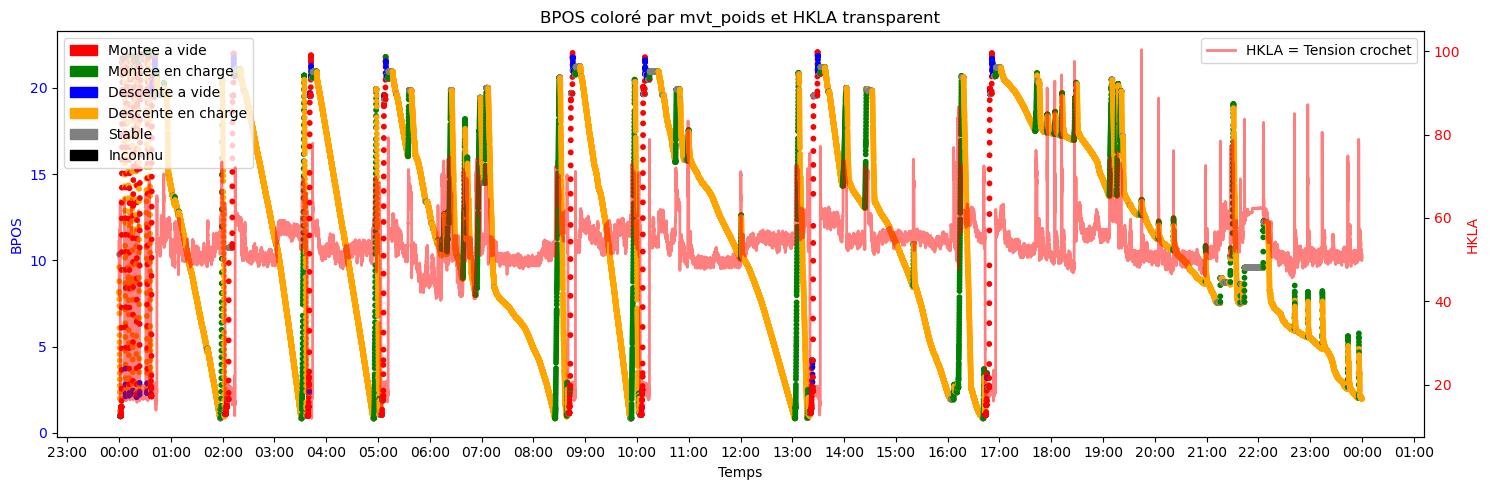

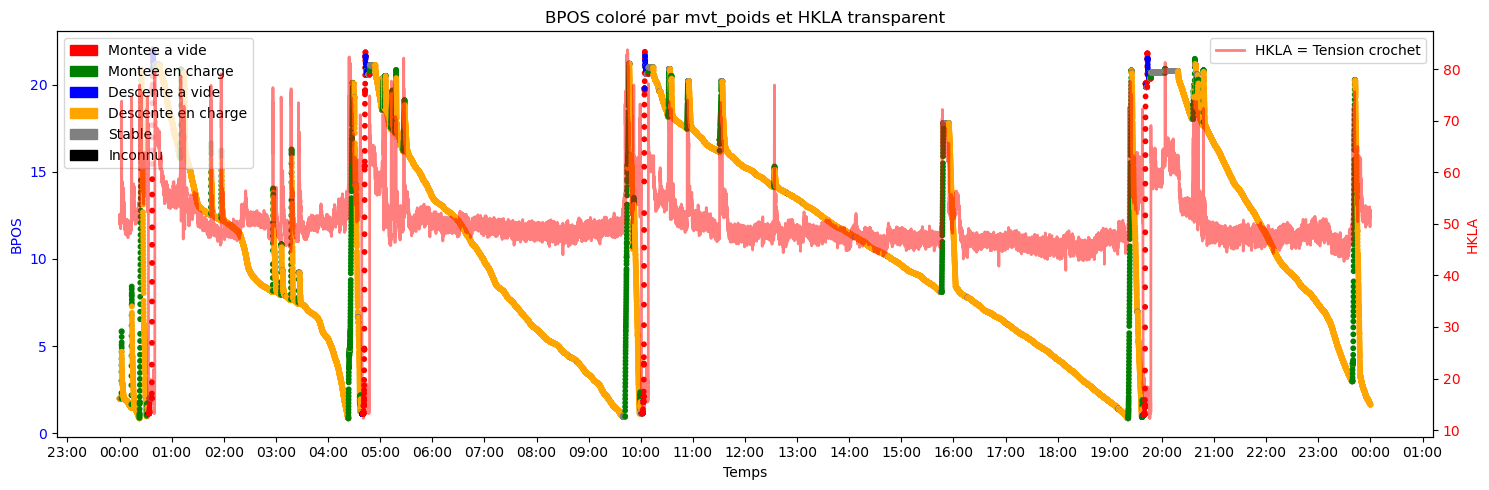

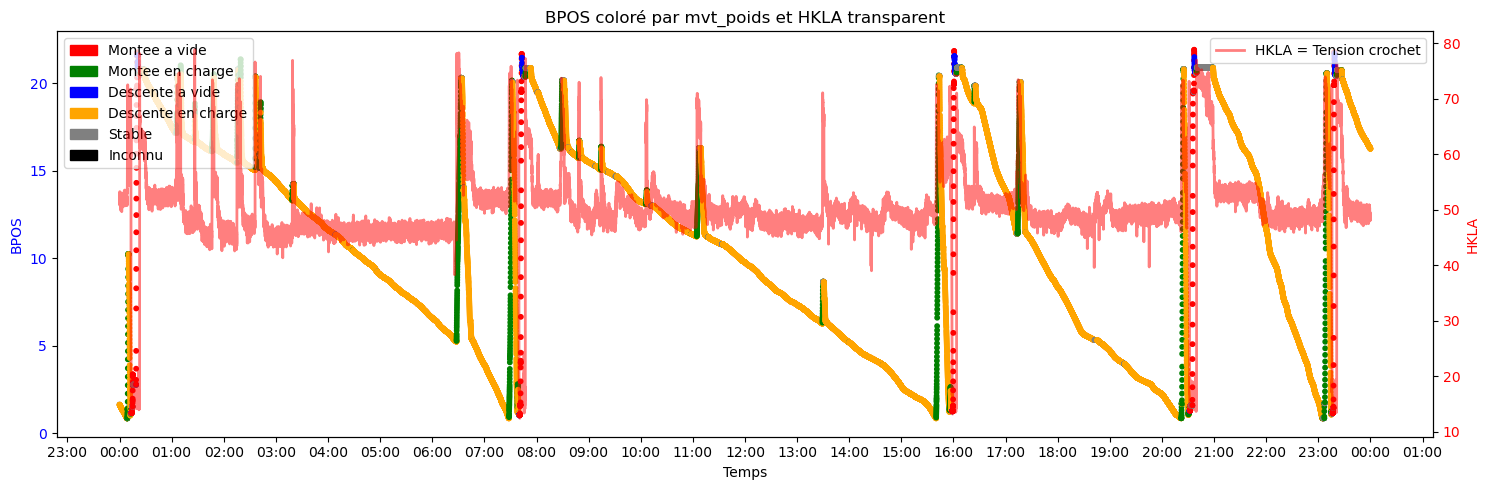

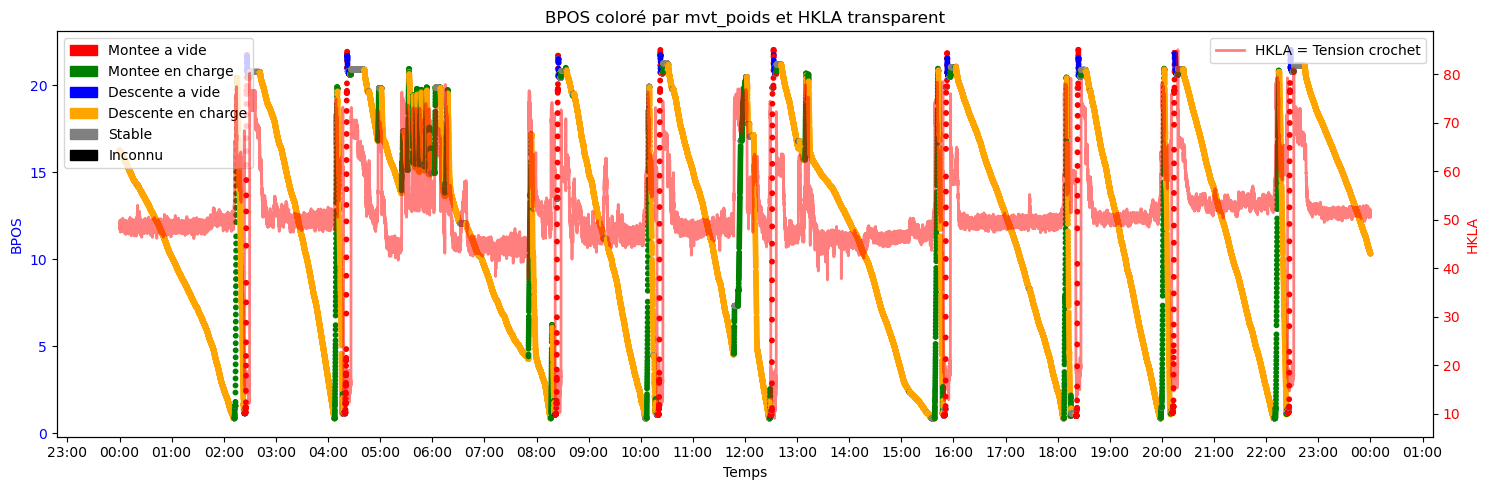

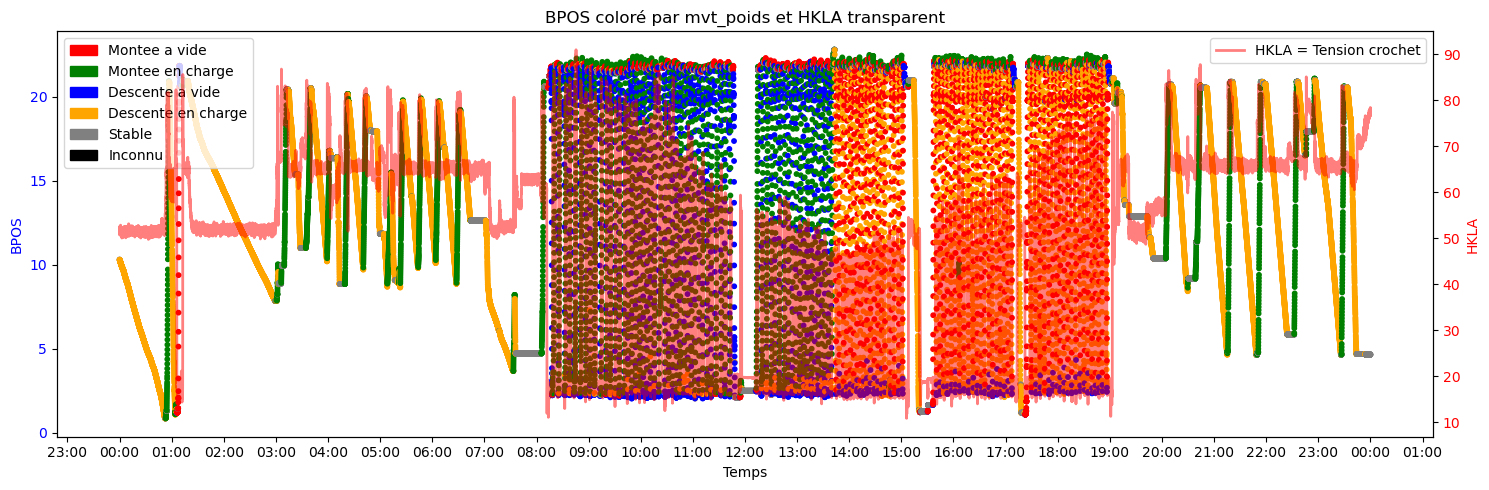

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches  # Pour la gestion de la légende personnalisée

# Fonction pour attribuer une couleur en fonction de la valeur de 'mvt_poids'
def get_color(mvt_poids_value):
    color_map = {
        "Montee a vide": 'red',
        "Montee en charge": 'green',
        "Descente a vide": 'blue',
        "Descente en charge": 'orange',
        "Stable": 'gray',
        "Inconnu": 'black'
    }
    return color_map.get(mvt_poids_value, 'black')  # Retourne noir par défaut si pas trouvé

# Boucle pour chaque DataFrame dans processed_data
for df in processed_data:
    df.reset_index(drop=True, inplace=True)  # Réinitialiser l'index sans ajouter l'index comme colonne

    fig, ax1 = plt.subplots(figsize=(15, 5))  # Créer une nouvelle figure et axe pour le premier graphique

    # Tracer BPOS coloré par mvt_poids
    colors_bpos = df['mvt_poids'].apply(get_color)  # Assigner les couleurs à chaque point en fonction de 'mvt_poids'
    scatter_bpos = ax1.scatter(df['TIME'], df['BPOS'], c=colors_bpos, label='BPOS = Position trépan', marker='o', s=10)

    ax1.set_xlabel('Temps')
    ax1.set_ylabel('BPOS', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Créer un deuxième axe Y pour HKLA
    ax2 = ax1.twinx()

    # Tracer HKLA comme une ligne continue avec transparence
    ax2.plot(df['TIME'], df['HKLA'], c='red', label='HKLA = Tension crochet', lw=2, alpha=0.5)  # Ligne transparente pour HKLA

    ax2.set_ylabel('HKLA', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Créer la légende personnalisée pour mvt_poids
    color_map = {
        "Montee a vide": 'red',
        "Montee en charge": 'green',
        "Descente a vide": 'blue',
        "Descente en charge": 'orange',
        "Stable": 'gray',
        "Inconnu": 'black'
    }

    # Créer des éléments de légende pour chaque type de mvt_poids
    legend_labels = [mpatches.Patch(color=color_map[key], label=key) for key in color_map]

    # Ajouter la légende pour mvt_poids
    ax1.legend(handles=legend_labels, loc='upper left')

    # Ajouter une légende pour HKLA
    ax2.legend(loc='upper right')

    # Formatage de l'axe X pour afficher les heures
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Définit les ticks toutes les heures
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format de l'heure : Heure:Minute
    plt.xticks(rotation=45)  # Rotation des labels de l'axe X pour lisibilité

    # Ajouter un titre
    plt.title('BPOS coloré par mvt_poids et HKLA transparent')

    # Afficher le graphique
    plt.tight_layout()
    plt.show()


# Avoir un csv du résultat

In [10]:
pd.concat(processed_data).to_csv('processed_data.csv')

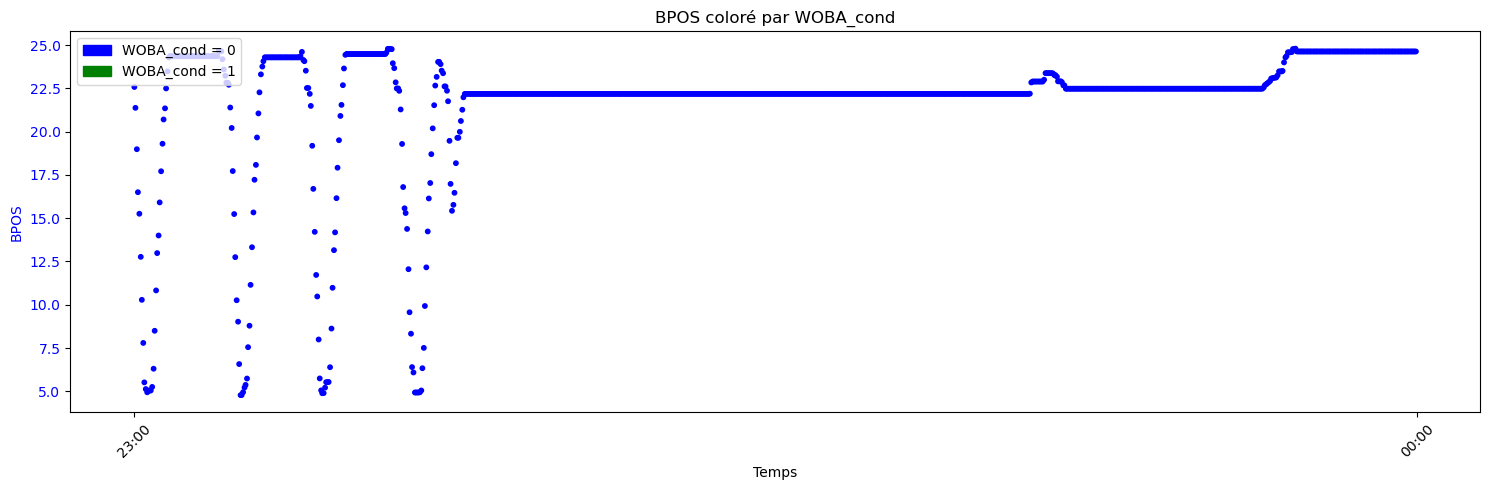

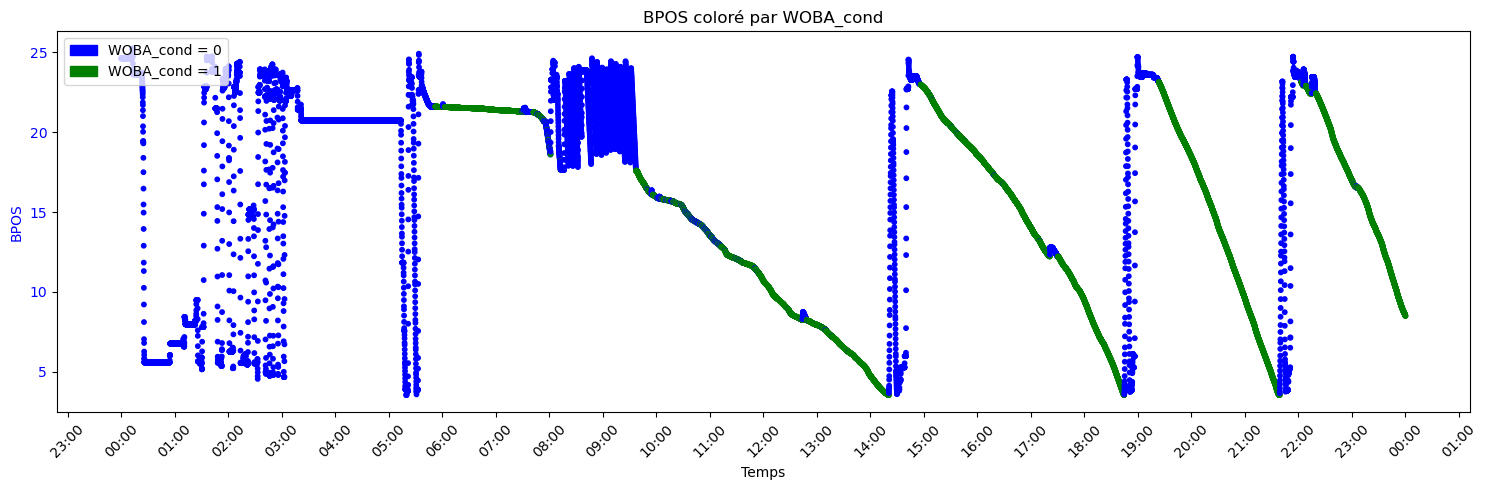

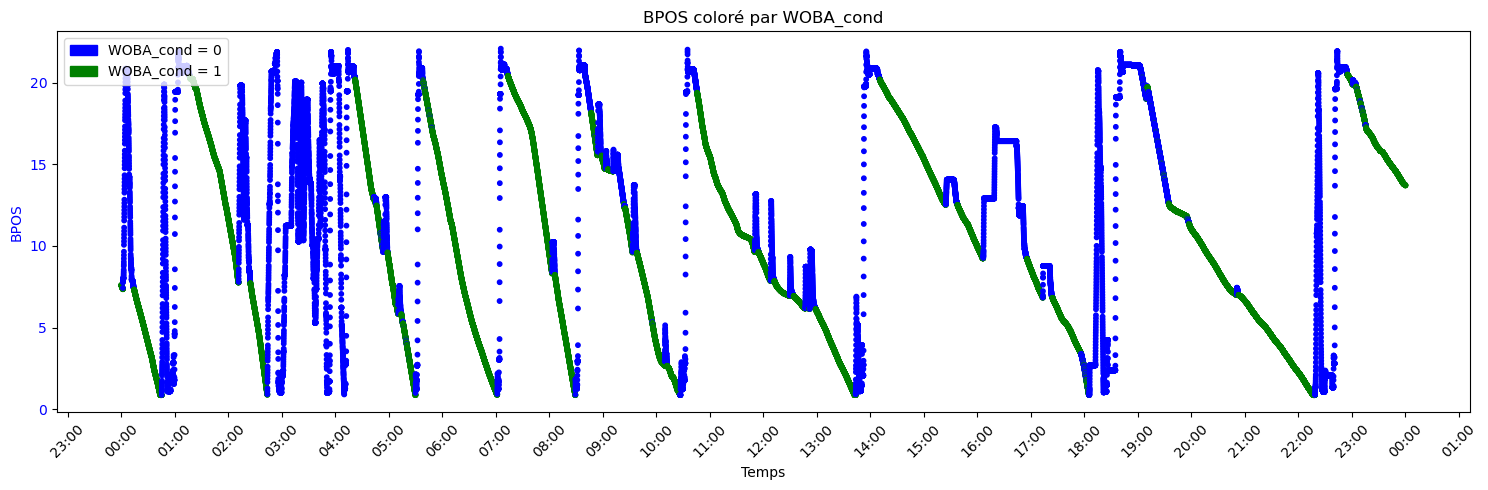

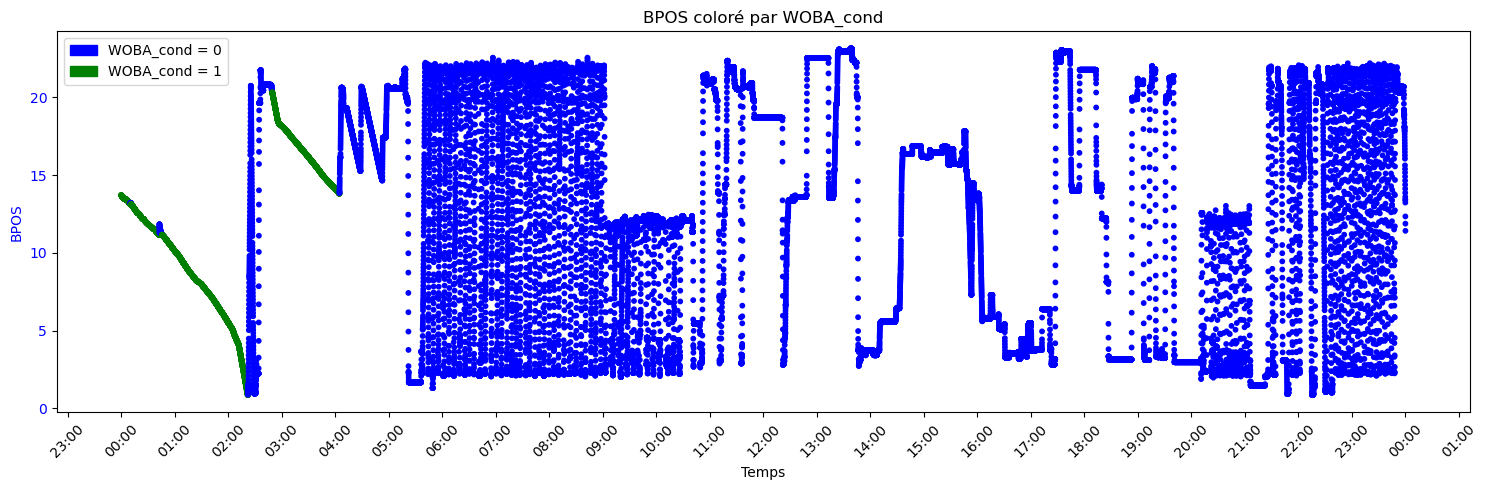

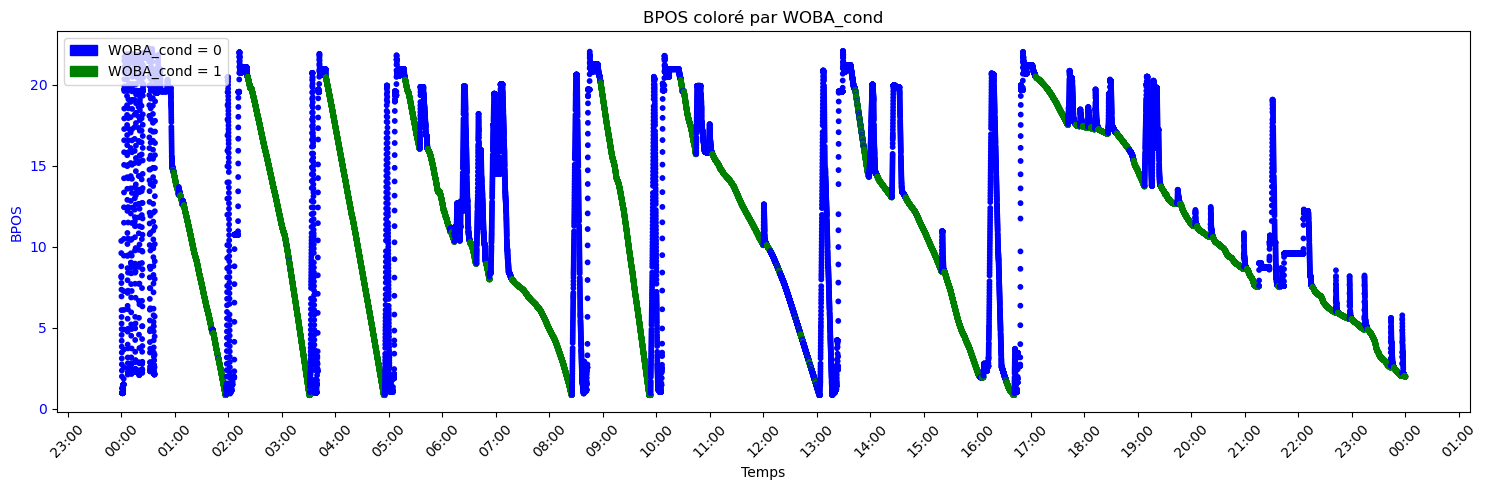

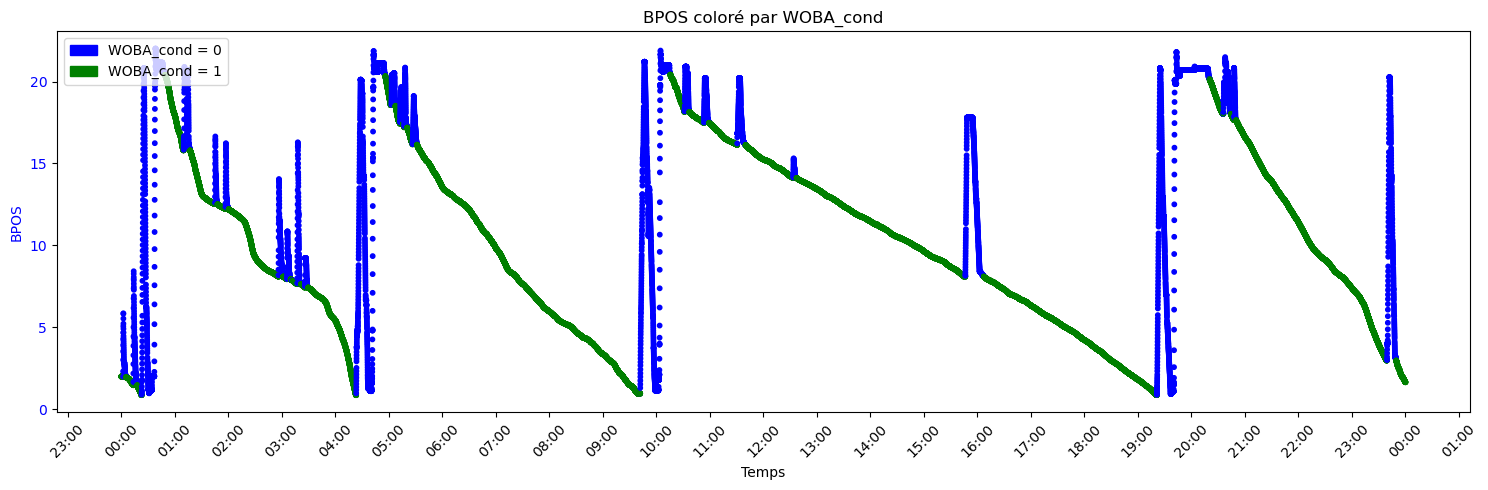

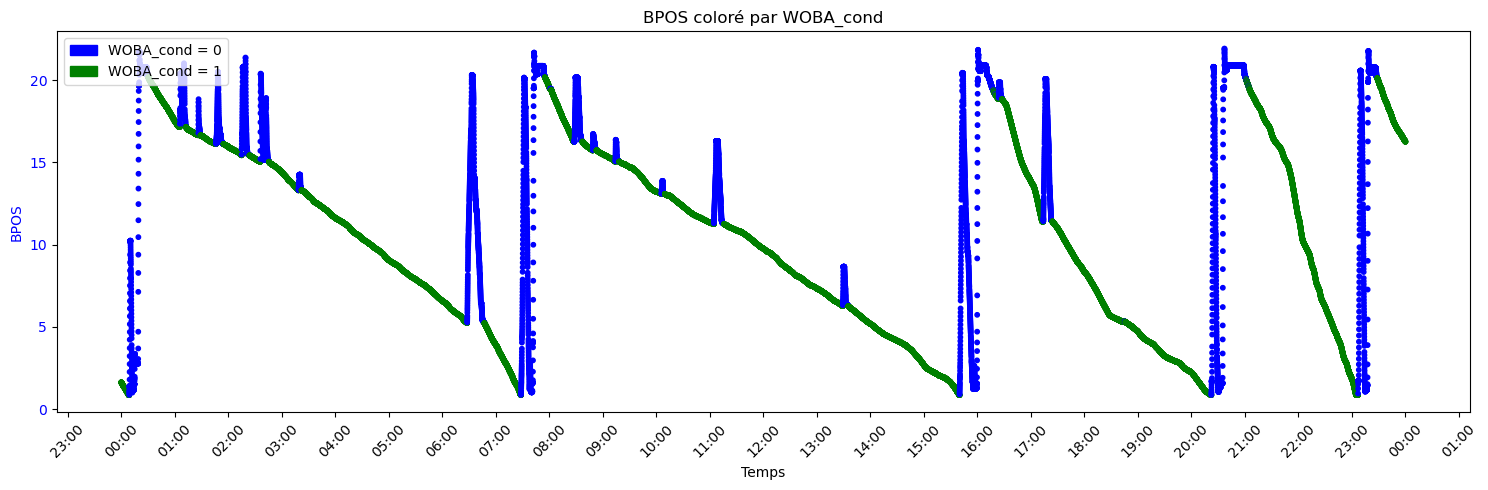

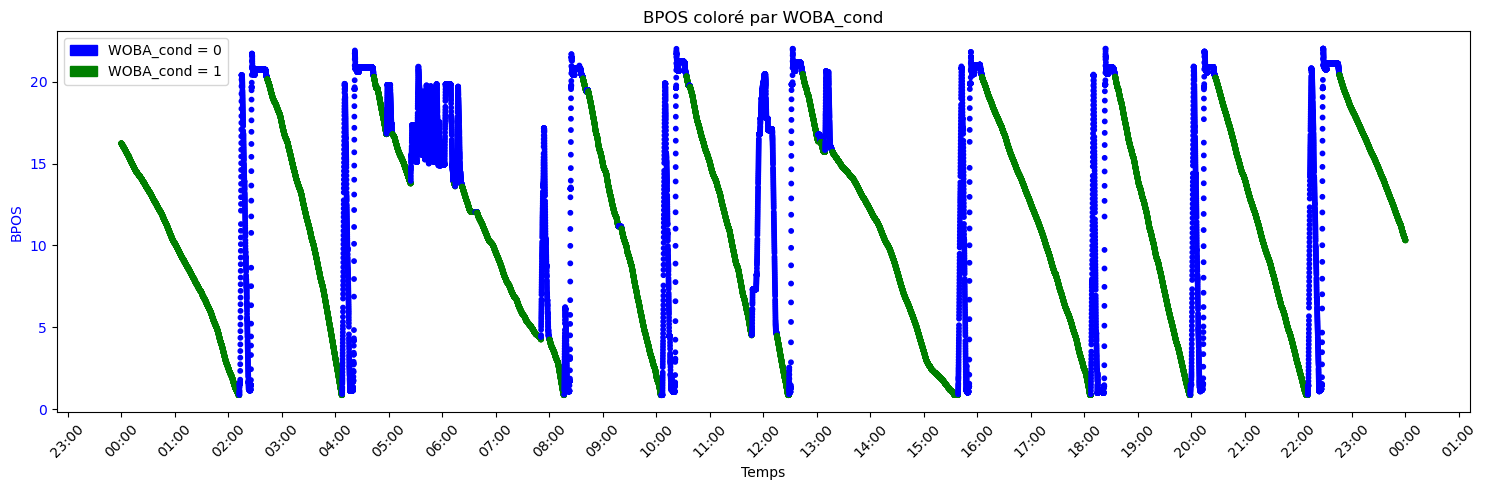

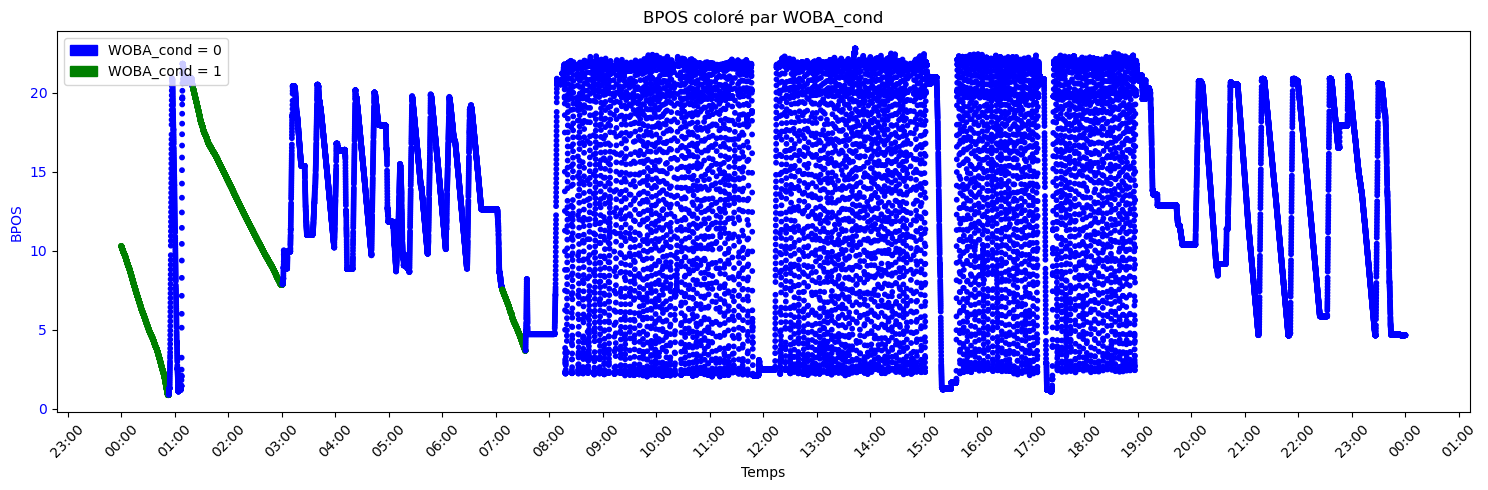

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Pour la gestion de la légende personnalisée

# Fonction pour attribuer une couleur en fonction de 'WOBA_cond'
def get_color(WOBA_cond_value):
    color_map = {
        0: 'blue',  # Si WOBA_cond == 0
        1: 'green',  # Si WOBA_cond == 1
    }
    return color_map.get(WOBA_cond_value, 'black')  # Retourne noir par défaut si pas trouvé

# Boucle pour chaque DataFrame dans processed_data
for df in processed_data:
    df.reset_index(drop=True, inplace=True)  # Réinitialiser l'index sans ajouter l'index comme colonne

    fig, ax = plt.subplots(figsize=(15, 5))  # Créer une nouvelle figure et axe pour le graphique

    # Tracer BPOS coloré par WOBA_cond
    colors_bpos = df['WOBA_cond'].apply(get_color)  # Assigner les couleurs à chaque point en fonction de 'WOBA_cond'
    scatter_bpos = ax.scatter(df['TIME'], df['BPOS'], c=colors_bpos, label='BPOS = Position trépan', marker='o', s=10)

    ax.set_xlabel('Temps')
    ax.set_ylabel('BPOS', color='b')
    ax.tick_params(axis='y', labelcolor='b')

    # Créer la légende personnalisée pour WOBA_cond
    color_map = {
        0: 'blue',  # WOBA_cond == 0
        1: 'green',  # WOBA_cond == 1
    }

    # Créer des éléments de légende pour chaque valeur de WOBA_cond
    legend_labels = [mpatches.Patch(color=color_map[key], label=f'WOBA_cond = {key}') for key in color_map]

    # Ajouter la légende pour WOBA_cond
    ax.legend(handles=legend_labels, loc='upper left')

    # Formatage de l'axe X pour afficher les heures
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Définit les ticks toutes les heures
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format de l'heure : Heure:Minute
    plt.xticks(rotation=45)  # Rotation des labels de l'axe X pour lisibilité

    # Ajouter un titre
    plt.title('BPOS coloré par WOBA_cond')

    # Afficher le graphique
    plt.tight_layout()
    plt.show()
